Run ONNX model on a segment & visualize predictions on a GIF.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from train.dataloader import load_transformed_video
from utils import Calibration, draw_path, FULL_FRAME_SIZE, extract_preds
from matplotlib.patches import Patch
from train.model import load_inference_model

In [2]:
plot_img_height, plot_img_width = 480, 640 # can be reduced for wandb

fill_color_gt = [0,  255, 0]
line_color_gt = [255,255, 0]
fill_color_preds = [0,  0,255]
line_color_preds = [200,0,255]
laneline_colors = [(255, 0, 0), (0, 255, 0), (255, 0, 255), (0, 255, 255)]

def legend_color(color, opacity=0.3):
    return np.append(np.array(color)/255, opacity)

### Load transformed and raw RGB video

In [3]:
path_to_segment = '/home/nikita/data/2021-09-14--09-19-21/25'
ORIGINAL_MODEL = 'common/models/supercombo.onnx'

os.makedirs('outs', exist_ok=True)

seq_len = 300

input_frames, rgb_frames = load_transformed_video(path_to_segment, seq_len=seq_len)

### Load model

In [4]:
path_to_model = 'mhp_3.8027_1.onnx'

model, run_model = load_inference_model(path_to_model)

FileNotFoundError: [Errno 2] No such file or directory: 'mhp_3.8027_1.onnx'

### Run model

In [ ]:
lanelines_preds = []
road_edges_preds = []
path_preds = []

recurrent_state = np.zeros((1, 512), dtype=np.float32)

for t_idx in range(seq_len):
    inputs = {
        'input_imgs': input_frames[t_idx:t_idx+1].numpy().astype(np.float32),
        'desire': np.zeros((1, 8), dtype=np.float32),
        'traffic_convention': np.array([0, 1], dtype=np.float32).reshape(1, 2),
        'initial_state': recurrent_state,
    }

    outs, recurrent_state = run_model(inputs)
    lanelines, road_edges, best_path = extract_preds(outs)[0]

    lanelines_preds.append(lanelines)
    road_edges_preds.append(road_edges)
    path_preds.append(best_path)

### Create gif

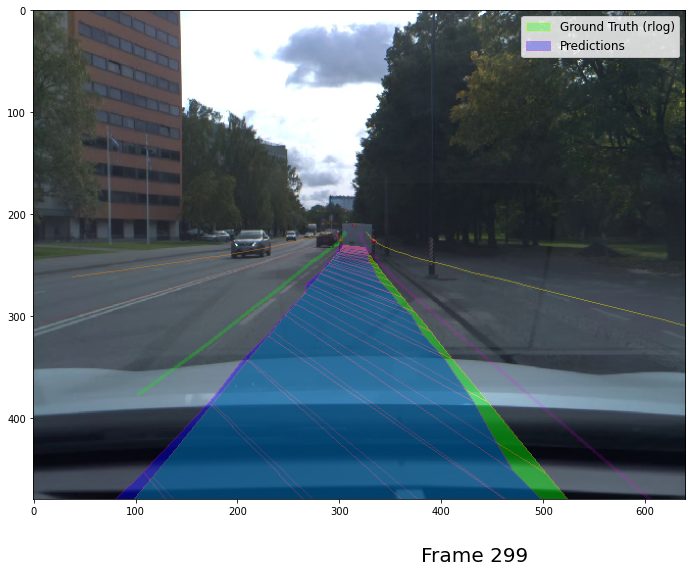

In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter


plot_width = 12
plot_height = plot_width * (FULL_FRAME_SIZE[1] / FULL_FRAME_SIZE[0])
fig, ax = plt.subplots(1,1, figsize=(plot_width, plot_height))

def animate(t_idx):
    # real calibration values during this ride, divided by 2 to account for not using calibration during inference
    rpy_calib_pred = np.array([0.00018335809, 0.034165092, -0.014245722]) / 2 
    calibration = Calibration(rpy_calib_pred, plot_img_width=plot_img_width, plot_img_height=plot_img_height)

    img_plot = draw_path(lanelines_preds[t_idx], road_edges_preds[t_idx], path_preds[t_idx][0, :, :3], rgb_frames[t_idx], calibration, laneline_colors, fill_color=fill_color_preds, line_color=line_color_preds)    

    ax.clear()
    txt = ax.text(plot_img_height-100, plot_img_width-100, f'Frame {t_idx}', fontsize=20)
    plt_img = ax.imshow(img_plot)

    return txt, plt_img

anim = FuncAnimation(fig, animate, interval=1000/20, blit=True, repeat=True, frames=len(path_preds))  
writer = FFMpegWriter(fps=20, bitrate=2000)
anim.save("outs/TLI.gif", writer=writer)